In [1]:
!pip install tensorflow  matplotlib kagglehub

In [2]:
import kagglehub
path = kagglehub.dataset_download("sivm205/soybean-diseased-leaf-dataset")

print("Path to dataset files:", path)

100%|██████████| 1.93G/1.93G [00:52<00:00, 39.5MB/s]


Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/sivm205/soybean-diseased-leaf-dataset/versions/1


In [3]:
import tensorflow as tf
from tensorflow import keras
from keras import models, layers
import matplotlib.pyplot as plt

In [4]:
IMAGE_SIZE = 360
BATCH_SIZE =32
CHANNELS=3
EPOCHS=50

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 701 files belonging to 10 classes.


In [6]:
class_names = dataset.class_names

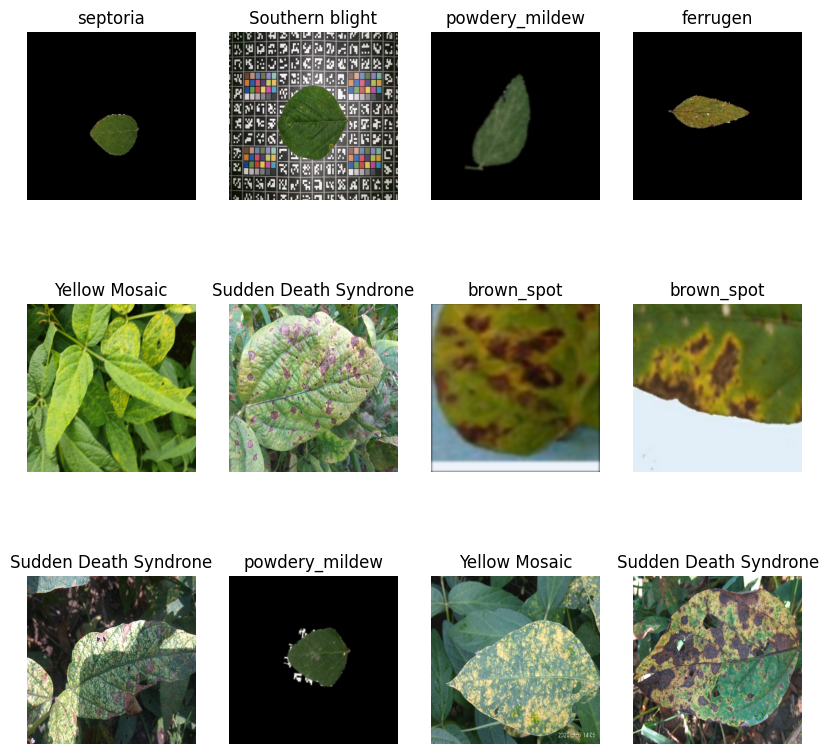

In [7]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")

In [8]:
def get_dataset_partition_tf(ds, train_split=0.8,validation_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
  ds_size = len(ds)
  if shuffle:
    ds = ds.shuffle(shuffle_size, seed=12)
  train_size = int(train_split * ds_size)

  val_size = int(validation_split * ds_size)

  train_ds = ds.take(train_size)

  val_ds= ds.skip(train_size).take(val_size)

  test_ds = ds.skip(train_size).skip(val_size)


  return train_ds, val_ds, test_ds

In [9]:
train_ds, val_ds, test_ds = get_dataset_partition_tf(dataset)

Next is caching and prefetching




In [10]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Next we do some preprocessing

In [20]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

Data Augmentation

In [21]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

The building of the actual Model

In [22]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE,CHANNELS)
n_classes = 3

model = models.Sequential([
     layers.InputLayer(shape=input_shape),
     resize_and_rescale,
     data_augmentation,
     layers.Conv2D(32,(3,3), activation='relu'),
     layers.MaxPooling2D((2,2)),
     layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
     layers.MaxPooling2D((2,2)),
     layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
     layers.MaxPooling2D((2,2)),
     layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
     layers.MaxPooling2D((2,2)),
     layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
     layers.MaxPooling2D((2,2)),
     layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
     layers.MaxPooling2D((2,2)),
     layers.Flatten(),
     layers.Dense(64, activation='relu'),
     layers.Dense(n_classes, activation='softmax')
 ])



In [23]:
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_7 (Sequential)            │ (None, 360, 360, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_8 (Sequential)            │ (None, 360, 360, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 358, 358, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_30 (MaxPooling2D)      │ (None, 179, 179, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 177, 177, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_31 (MaxPooling2D)      │ (None, 88, 88, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (None, 86, 86, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_32 (MaxPooling2D)      │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (None, 41, 41, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_33 (MaxPooling2D)      │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_34 (Conv2D)                   │ (None, 18, 18, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_34 (MaxPooling2D)      │ (None, 9, 9, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_35 (Conv2D)                   │ (None, 7, 7, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_35 (MaxPooling2D)      │ (None, 3, 3, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 576)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 204,227 (797.76 KB)

 Trainable params: 204,227 (797.76 KB)

 Non-trainable params: 0 (0.00 B)